## Lab assignment 02

### Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the RU-EN translation task.

Basic approach using RNNs as encoder and decoder is implemented for you.

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* Transformer/CNN/<whatever you select> encoder (with or without positional encoding)

* attention/self-attention mechanism (**highly recommended**)

* custom tokenization (BPE units, other subword approaches)

to improve the translation quality.

--------

* __Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

* Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [2]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
# path_to_data = '../../datasets/Machine_translation_EN_RU/data.txt'
# if not os.path.exists(path_to_data):
#     print("Dataset not found locally. Downloading from github.")
#     !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
#     path_to_data = './data.txt'

In [3]:
path_to_data = './data.txt'

#### Grading criteria

**100%**
- implementation of at least 3 model improvements over baseline
- threshold of 27 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**70%**
- implementation of at least 2 model improvements over baseline
- threshold of 25 BLEU on test corpus
- experimental results and conclusions in human-readable format :)

**30%**
- implementation of at least 1 model improvement over baseline
- threshold of 21 BLEU on test corpus
- experimental results and conclusions in human-readable format :)


------

#### **Note: Please do not use pretrained machine translation / BERT / LLM checkpoints. All such solutions will be graded at 30% pts.**


### Setup

Библиотеки

In [4]:
import collections
import IPython
import nltk
import numpy as np
import time
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchtext

/opt/calculation/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


В работе сделаны 3 улучшения базовой модели:
* механизм attention
* изменяемый learning rate
* трансформер

При этом везде используются одинаковые размеры embedding и другие гиперпараметры, чтобы наиболее объективно сравнивать между собой архитектуры моделей

Гиперпааметры

In [66]:
min_freq = 3
max_length = 60
batch_size = 128
clip = 1

train_part = 0.8
val_part = 0.15

n_show = 1
n_val = 100

# Baseline
base_enc_layers = 1
base_dec_layers = 1
base_dropout_p = 0.5
base_lr = 0.001
base_emb_size = 300
base_hid_size = 300
base_path = 'base.pt'

# Attention
att_enc_layers = 1
att_dec_layers = 1
att_dropout_p = 0.5
att_lr = 0.001
att_emb_size = 300
att_hid_size = 300
att_path = 'att.pt'

# Attention + learning rate adjustment
att_lr_path = 'att_lr.pt'

# Transformer
transf_enc_layers = 1
transf_dec_layers = 1
transf_emb_size = 300
n_head = 2
dim_feedforward = 300
transf_dropout_p = 0
transf_lr = 0.001
transf_path = 'transf.pt'

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Предобработка

Разбиваем данные на пары английских и русских примеров

In [7]:
dataset = []

with open(path_to_data) as data:
  examples = data.readlines()

for ex in examples:
  src_sample, targ_sample = ex.strip().split('\t')
  dataset.append({'en': src_sample, 'rus': targ_sample})

n_examples = len(dataset)

print('Samples in dataset:', n_examples)
print('English example:', dataset[0]['en'])
print('Russian example:', dataset[0]['rus'])

Samples in dataset: 50000
English example: Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.
Russian example: Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.


Токенизируем данные

In [8]:
tokenizer = nltk.tokenize.wordpunct_tokenize
tok_data = [{'en': tokenizer(pair['en'].lower()),
             'rus': tokenizer(pair['rus'].lower())} for pair in dataset]

print('Samples in dataset:', len(tok_data))
print('Tokenized english:', tok_data[9]['en'][:15])
print('Tokenized russian:', tok_data[9]['rus'][:15])
print('English length:', len(tok_data[9]['en']))
print('Rissian length:', len(tok_data[9]['rus']))

Samples in dataset: 50000
Tokenized english: ['the', 'danube', 'delta', 'is', 'a', 'natural', 'reserve', 'where', 'you', 'can', 'go', 'fishing', ',', 'bird', 'watching']
Tokenized russian: ['дельта', 'дуная', 'является', 'природным', 'заповедником', ',', 'в', 'котором', 'можно', 'заняться', 'рыбной', 'ловлей', ',', 'понаблюдать', 'за']
English length: 26
Rissian length: 27


Создаём словарь

In [9]:
specials = ('<UNK>', '<SOS>', '<EOS>', '<PAD>')

en_tokens = collections.Counter()
rus_tokens = collections.Counter()

for pair in tok_data:
  en_tokens.update(pair['en'])
  rus_tokens.update(pair['rus'])

en_voc = torchtext.vocab.vocab(en_tokens, min_freq=min_freq, specials=specials)
rus_voc = torchtext.vocab.vocab(rus_tokens, min_freq=min_freq,
                                specials=specials)

en_voc.set_default_index(en_voc['<UNK>'])
rus_voc.set_default_index(rus_voc['<UNK>'])

voc = {'en': en_voc, 'rus': rus_voc}

input_size = len(voc['rus'])
output_size = len(voc['en'])

en_sos_idx = voc['en']['<SOS>']
rus_sos_idx = voc['rus']['<SOS>']

en_eos_idx = voc['en']['<EOS>']
rus_eos_idx = voc['rus']['<EOS>']

en_pad_idx = voc['en']['<PAD>']
rus_pad_idx = voc['rus']['<PAD>']

en_unk_idx = voc['en']['<UNK>']
rus_unk_idx = voc['rus']['<UNK>']

print('English vocabulary size:', output_size)
print('Russian vocabulary size:', input_size)

print('Russian tokens:', voc['rus'].lookup_tokens(list(range(10))))
print('English tokens:', voc['en'].lookup_tokens(list(range(10))))

English vocabulary size: 7828
Russian vocabulary size: 10799
Russian tokens: ['<UNK>', '<SOS>', '<EOS>', '<PAD>', 'отель', 'расположен', 'в', 'тбилиси', ',', '3']
English tokens: ['<UNK>', '<SOS>', '<EOS>', '<PAD>', 'hotel', 'is', 'situated', 'in', 'tbilisi', ',']


Заменяем токены на индексы в словаре

In [10]:
indexed_data = [{'en': [voc['en']['<SOS>']] +
                     [voc['en'][token] for token in pair['en']] +
                     [voc['en']['<EOS>']],
               'rus': [voc['rus']['<SOS>']] +
                      [voc['rus'][token] for token in pair['rus']] +
                      [voc['rus']['<EOS>']]} for pair in tok_data]

print('Amount of samples:', n_examples)

print('English sentence:', indexed_data[9]['en'])
print('Russian sentence:', indexed_data[9]['rus'])

print('English length:', len(indexed_data[9]['en']))
print('Russian length:', len(indexed_data[9]['rus']))

Amount of samples: 50000
English sentence: [1, 67, 88, 89, 5, 10, 90, 91, 92, 23, 70, 93, 94, 9, 95, 96, 9, 97, 98, 99, 100, 101, 102, 103, 104, 105, 20, 2]
Russian sentence: [1, 98, 99, 100, 101, 102, 8, 6, 103, 91, 104, 105, 106, 8, 107, 95, 108, 8, 109, 89, 110, 111, 112, 113, 6, 114, 115, 16, 2]
English length: 28
Russian length: 29


Распределение длинн последовательностей

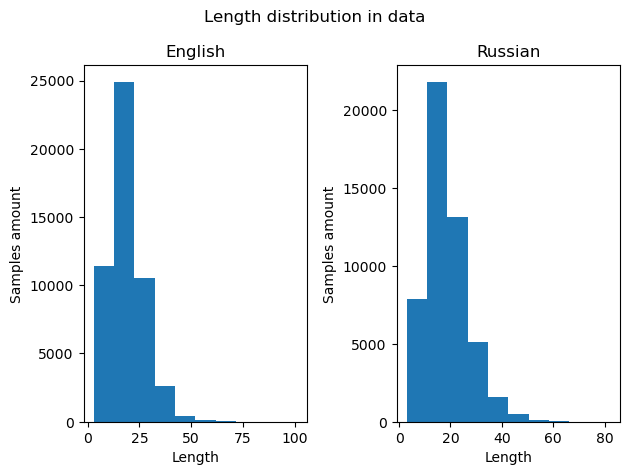

In [11]:
en_length = map(len, [indexed_data[i]['en'] for i in range(n_examples)])
rus_length = map(len, [indexed_data[i]['rus'] for i in range(n_examples)])

fig = plt.figure()
fig.suptitle('Length distribution in data')

plt.subplot(1, 2, 1)
plt.title("English")
plt.xlabel('Length')
plt.ylabel('Samples amount')
plt.hist(list(en_length))

plt.subplot(1, 2, 2)
plt.title("Russian")
plt.xlabel('Length')
plt.ylabel('Samples amount')
plt.hist(list(rus_length))

plt.tight_layout()
plt.show()

#### Предобработка для Seq2Seq
Делаем паддинг и разбиваем данные на обучающие, валидационные и тестовые

Паддинг

In [12]:
pad_en_list = []
pad_rus_list = []

for pair in indexed_data:
  pad_en = pair['en'][:max_length] + [en_pad_idx] * (max_length - len(pair['en']))
  pad_rus = pair['rus'][:max_length] + [rus_pad_idx] * (max_length - len(pair['rus']))

  pad_en_list.append(pad_en)
  pad_rus_list.append(pad_rus)

padded_data = {'en': torch.tensor(pad_en_list),
               'rus': torch.tensor(pad_rus_list)}

print('Data tensor shape:', padded_data['en'].shape)
print('Example sentence:', padded_data['en'][1])

Data tensor shape: torch.Size([50000, 60])
Example sentence: tensor([ 1, 21,  0, 22, 23, 24, 25, 10, 26, 12, 27, 28, 29,  9, 30, 31,  9, 32,
        10, 33, 34, 20,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3])


Разбиваем данные на тренировочные, валидационные и тестовые

In [13]:
examples = list(zip(padded_data['en'], padded_data['rus']))

train_size = round(train_part * n_examples)
val_size = round(val_part * n_examples)
test_size = round((1 - train_part - val_part) * n_examples)

train_data, val_data, test_data = torch.utils.data.random_split(examples,
                                              [train_size, val_size, test_size])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           shuffle=True, num_workers=2,
                                           drop_last=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         drop_last=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                          shuffle=False, num_workers=2,
                                          drop_last=True)

print('Train size:', len(train_data))
print('Val size:', len(val_data))
print('Test size:', len(test_data))

Train size: 40000
Val size: 7500
Test size: 2500


#### Предобработка для трансформера
Для трансформера удобнее сделать batch_first=False. Также используем встроенную в torch функцию для паддинга

Разбиваем данные на тренировочные, валидационные и тестовые

In [14]:
en_indexed = [indexed_data[idx]['en'] for idx in range(n_examples)]
ru_indexed = [indexed_data[idx]['rus'] for idx in range(n_examples)]

data = []

for (ru_idxs, en_idxs) in zip(ru_indexed, en_indexed):
  ru_tensor_ = torch.tensor(ru_idxs, dtype=torch.long)
  en_tensor_ = torch.tensor(en_idxs, dtype=torch.long)
  data.append((ru_tensor_, en_tensor_))

train_size = round(train_part * n_examples)
val_size = round(val_part * n_examples)
test_size = round((1 - train_part - val_part) * n_examples)

train_data, val_data, test_data = torch.utils.data.random_split(data,
                                                                [train_size,
                                                                 val_size,
                                                                 test_size])
print('Train size:', len(train_data))
print('Val size:', len(val_data))
print('Test size:', len(test_data))

Train size: 40000
Val size: 7500
Test size: 2500


In [15]:
def generate_batch(data_batch):
    ru_batch, en_batch = [], []

    for (ru_item, en_item) in data_batch:
        ru_batch.append(torch.cat([torch.tensor([rus_sos_idx]), ru_item,
                                   torch.tensor([rus_eos_idx])], dim=0))
        en_batch.append(torch.cat([torch.tensor([en_sos_idx]), en_item,
                                   torch.tensor([en_eos_idx])], dim=0))

    ru_batch = torch.nn.utils.rnn.pad_sequence(ru_batch, batch_first=False,
                                               padding_value=rus_pad_idx)
    en_batch = torch.nn.utils.rnn.pad_sequence(en_batch, batch_first=False,
                                                padding_value=en_pad_idx)
    return ru_batch, en_batch

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, collate_fn=generate_batch)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                       shuffle=False, collate_fn=generate_batch)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                        shuffle=False, collate_fn=generate_batch)

### Обучение модели


#### Функции для обучения и визуализации

In [16]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    return elapsed_mins, int(elapsed_time - (elapsed_mins * 60))

In [17]:
def plot(train_hist, val_hist, bleu_hist, batches):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
  IPython.display.clear_output(True)

  ax[0].set_xlabel('Batch')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Learning curve')
  ax[0].plot(train_hist, label='train')
  ax[0].plot(batches, val_hist, label='val')
  ax[0].legend()

  ax[1].set_xlabel('Batch')
  ax[1].set_ylabel('Bleu')
  ax[1].set_title('Validation bleu')
  ax[1].plot(batches, bleu_hist)

  plt.tight_layout()
  plt.show()

Заменяет последовательность индексов на последовательность токенов

In [18]:
def transl(indices):
  translated = []

  for idx in indices:
    if idx not in [en_sos_idx, en_eos_idx, en_pad_idx]:
      translated.append(voc['en'].lookup_token(idx))
    elif idx == en_eos_idx:
      break
  return translated

##### Функции для Seq2Seq

In [19]:
def evaluate(model):
    model.eval()
    eval_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            trg = batch[0].to(device)
            output = model(batch[1].to(device), trg)
            output = output.view(-1, output.shape[-1])
            loss = criterion(output, trg.view(-1))
            eval_loss += loss.item()

    model.train()
    return eval_loss / len(val_loader)

In [20]:
def get_bleu(model, loader):
  translated_sentences = []
  target_sentences = []

  for batch in loader:
      src = batch[1].to(device)
      trg = batch[0]

      model.eval()
      trg_indices = trg.tolist()

      with torch.no_grad():
          translated_indices = model(src).argmax(dim=-1).cpu().numpy().tolist()

          for indices in translated_indices:
              translated_sentences.append(transl(indices))

          for indices in trg_indices:
              target_sentences.append(transl(indices))

  bleu_score = nltk.translate.bleu_score.corpus_bleu([[text] for text in target_sentences],
                                                    translated_sentences) * 100
  model.train()
  return translated_sentences, target_sentences, bleu_score

In [21]:
def train_and_plot(model, use_sheduler, epochs, path,
                   train_history, val_history, bleu_history, val_batches):
  model.train()

  for epoch in range(epochs):
      start_time = time.time()
      epoch_loss = 0
      val_loss = 0
      bleu = 0

      for i, batch in enumerate(train_loader):
          trg = batch[0].to(device)
          optimizer.zero_grad()
          output = model(batch[1].to(device), trg)
          output = output.view(-1, output.shape[-1])
          loss = criterion(output, trg.view(-1))
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
          optimizer.step()
          train_history.append(loss.detach().cpu().data.numpy())

          if (i + 1) % n_val == 0:
              if len(val_batches) == 0:
                val_batches.append(i)
              else:
                val_batches.append(val_batches[-1] + n_val)
              val_loss = evaluate(model)
              val_history.append(val_loss)
              _, _, bleu = get_bleu(model, val_loader)
              bleu_history.append(bleu)
              plot(train_history, val_history, bleu_history, val_batches)
          elif (i + 1) % n_show == 0:
              plot(train_history, val_history, bleu_history, val_batches)

      train_loss = train_history[-1]
      end_time = time.time()
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      torch.save(model.state_dict(), path)

      if use_sheduler:
        scheduler.step(val_loss)

      print(f'Time: {epoch_mins}m {epoch_secs}s')

      print(f'\tTrain Loss: {train_loss:.1f} | Train PPL: {np.exp(train_loss):.0f}')
      print(f'\t Val. Loss: {val_loss:.1f} |  Val. PPL: {np.exp(val_loss):.0f}')
      print(f'\t Bleu: {bleu:.1f}')

  return(train_history, val_history, bleu_history, val_batches)

##### Функции для трансформера

In [22]:
def evaluate(model):
    model.eval()
    losses = 0

    with torch.no_grad():
      for src, tgt in val_loader:
          src = src.to(device)
          tgt = tgt.to(device)

          tgt_input = tgt[:-1, :]
          src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
          logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
          loss = criterion(logits.reshape(-1, logits.shape[-1]), tgt[1:, :].reshape(-1))
          losses += loss.item()

    model.train()
    return losses / len(val_loader)

In [23]:
def greedy_decode(model, src, src_mask, src_padding_mask, max_len, start_symbol):
    src = src.to(device)
    src_mask = src_mask.to(device)

    memory = model.encode(src, src_mask, src_padding_mask)
    ys = torch.ones(1, src.shape[1]).fill_(start_symbol).type(torch.long).to(device)
    for i in range(max_len-1):
        memory = memory.to(device)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(device)
        out = model.decode(ys, memory, tgt_mask, src_padding_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)

        ys = torch.cat([ys, next_word.unsqueeze(0)], dim=0)
    return ys

In [45]:
def get_bleu(model, loader):
    translated_sentences = []
    target_sentences = []
    model.eval()

    for batch in loader:
        src = batch[0].to(device)
        trg = batch[1].to(device)

        num_tokens = src.shape[0]
        src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
        src_padding_mask = (src == rus_pad_idx).transpose(0, 1)

        with torch.no_grad():
            translated_indices = greedy_decode(model, src, src_mask, src_padding_mask,
                                               max_length, en_sos_idx)
            translated_indices = translated_indices.transpose(0, 1).cpu().tolist()
            trg_indices = trg.transpose(0, 1).cpu().tolist()

            for indices in translated_indices:
                translated_sentences.append(transl(indices))

            for indices in trg_indices:
                target_sentences.append(transl(indices))

    bleu_score = nltk.translate.bleu_score.corpus_bleu([[text] for text in target_sentences], translated_sentences) * 100
    model.train()
    return bleu_score, translated_sentences, target_sentences

In [46]:
def train_and_plot(model, use_sheduler, epochs, path,
                   train_history, val_history, bleu_history, val_batches):
  model.train()

  for epoch in range(epochs):
      start_time = time.time()
      epoch_loss = 0
      val_loss = 0
      bleu = 0

      for i, batch in enumerate(train_loader):
          src = batch[0].to(device)
          trg = batch[1].to(device)

          trg_input = trg[:-1, :]
          trg_out = trg[1:, :]

          optimizer.zero_grad()
          src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, trg_input)
          output = model(src, trg_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask, src_padding_mask)
          loss = criterion(output.reshape(-1, output.shape[-1]), trg_out.reshape(-1))
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
          optimizer.step()
          train_history.append(loss.detach().cpu().data.numpy())

          if (i + 1) % n_val == 0:
              if len(val_batches) == 0:
                val_batches.append(i)
              else:
                val_batches.append(val_batches[-1] + n_val)
              val_loss = evaluate(model)
              val_history.append(val_loss)
              bleu, _, _ = get_bleu(model, val_loader)
              bleu_history.append(bleu)
              plot(train_history, val_history, bleu_history, val_batches)
          elif (i + 1) % n_show == 0:
              plot(train_history, val_history, bleu_history, val_batches)

      train_loss = train_history[-1]
      end_time = time.time()
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)
      torch.save(model.state_dict(), path)

      if use_sheduler:
        scheduler.step(val_loss)

      print(f'Time: {epoch_mins}m {epoch_secs}s')

      print(f'\tTrain Loss: {train_loss:.1f} | Train PPL: {np.exp(train_loss):.0f}')
      print(f'\t Val. Loss: {val_loss:.1f} |  Val. PPL: {np.exp(val_loss):.0f}')
      print(f'\t Bleu: {bleu:.1f}')

  return(train_history, val_history, bleu_history, val_batches)

#### Базовая модель

Только encoder и decoder

In [47]:
class Encoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size,
                 hidden_size, n_layers, dropout_p):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.rnn = torch.nn.GRU(embedding_size, hidden_size,
                                batch_first=True, num_layers=n_layers)
        self.dropout = torch.nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded)
        return output, hidden

In [48]:
class Decoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size,
                 output_size, n_layers, dropout_p):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.rnn = torch.nn.GRU(embedding_size, hidden_size,
                                batch_first=True, num_layers=n_layers)
        self.dropout = torch.nn.Dropout(dropout_p)
        self.out = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        output, hidden = self.rnn(self.embedding(input), hidden)
        output = self.out(output)
        return output, hidden

In [49]:
class Seq2Seq(torch.nn.Module):
    def __init__(self, encoder, decoder, device,
                 batch_size, trgt_sos_idx, max_length):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.batch_size = batch_size
        self.sos = trgt_sos_idx
        self.max_length = max_length

    def forward(self, input, target_tensor=None):
        encoder_outputs, encoder_hidden = self.encoder(input)
        decoder_input = torch.empty(self.batch_size, 1, dtype=torch.long,
                                    device=device).fill_(self.sos)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(max_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input,
                                                          decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs

In [50]:
encoder = Encoder(input_size, base_emb_size, base_hid_size,
                  base_enc_layers, base_dropout_p)
decoder = Decoder(output_size, base_emb_size, base_hid_size,
                  output_size, base_dec_layers, base_dropout_p)

model = Seq2Seq(encoder, decoder, device,
                batch_size, en_sos_idx, max_length).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
criterion = torch.nn.CrossEntropyLoss(ignore_index=en_pad_idx)

train_history = []
val_history = []
bleu_history = []
val_batches = []

В одной эпохе содержится 300 батчей. Эта модель обучалась 6000 батчей, то есть 20 эпох. Видно, что после 10 эпохи bleu достигает 17 и дальше увеличивается незначительно. При этом на одну эпоху уходит примерно 3.5 минуты

In [51]:
train_history, val_history, bleu_history, val_batches = train_and_plot(model, False, 20, base_path,
                                                                       train_history, val_history, bleu_history, val_batches)

TypeError: forward() takes from 2 to 3 positional arguments but 8 were given

#### Attention

Применяем механизм attention, который улучшает embedding для каждого токена на основе его связи с контекстом

In [52]:
class Attention(torch.nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.Wa = torch.nn.Linear(hidden_size, hidden_size)
        self.Ua = torch.nn.Linear(hidden_size, hidden_size)
        self.Va = torch.nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = torch.nn.functional.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context

In [53]:
class AttnDecoder(torch.nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size,
                 output_size, n_layers, dropout_p):
        super(AttnDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.embedding = torch.nn.Embedding(input_size, embedding_size)
        self.attention = Attention(hidden_size)
        self.rnn = torch.nn.GRU(embedding_size + hidden_size, hidden_size,
                                batch_first=True, num_layers=n_layers)
        self.dropout = torch.nn.Dropout(dropout_p)
        self.out = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)
        query = hidden.permute(1, 0, 2)
        context = self.attention(query, encoder_outputs)
        input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(input, hidden)
        output = self.out(output)
        return output, hidden

In [54]:
class AttnSeq2Seq(torch.nn.Module):
    def __init__(self, encoder, decoder, device,
                 batch_size, trgt_sos_idx, max_length):
        super(AttnSeq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.batch_size = batch_size
        self.sos = trgt_sos_idx
        self.max_length = max_length

    def forward(self, input, target_tensor=None):
        encoder_outputs, encoder_hidden = self.encoder(input)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long,
                                    device=device).fill_(self.sos)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(self.max_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input,
                                                          decoder_hidden,
                                                          encoder_outputs)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs

In [55]:
encoder = Encoder(input_size, att_emb_size,
                  att_hid_size, att_enc_layers, att_dropout_p)
decoder = AttnDecoder(output_size, att_emb_size, att_hid_size,
                  output_size, att_dec_layers, att_dropout_p)

model = AttnSeq2Seq(encoder, decoder, device,
                batch_size, en_sos_idx, max_length).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=att_lr)
criterion = torch.nn.CrossEntropyLoss(ignore_index=en_pad_idx)

train_history = []
val_history = []
bleu_history = []
val_batches = []

По опыту предыдущей модели, эту обучал в течение 10 эпох. Видно,  bleu примерно в 1.5 превышает значение для базовой модели и на конец 10 эпохи составляет 27. При этом само обучение идёт чуть дольше, 4.5 минуты на эпоху вместо 3.5

In [56]:
train_history, val_history, bleu_history, val_batches = train_and_plot(model, False, 10, att_path,
                                                                       train_history, val_history, bleu_history, val_batches)

TypeError: forward() takes from 2 to 3 positional arguments but 8 were given

#### Attention + изменение learning rate

Уменьшаем learning rate как только loss на валидации выхоит на плато

In [57]:
encoder = Encoder(input_size, att_emb_size, att_hid_size,
                  att_enc_layers, att_dropout_p)
decoder = AttnDecoder(output_size, att_emb_size, att_hid_size,
                  output_size, att_dec_layers, att_dropout_p)

model = AttnSeq2Seq(encoder, decoder, device,
                batch_size, en_sos_idx, max_length).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=att_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                       patience=0)
criterion = torch.nn.CrossEntropyLoss(ignore_index=en_pad_idx)

train_history = []
val_history = []
bleu_history = []
val_batches = []

При использовании lr_scheduler значение bleu на отложенной выборке увеличилось на 1.5 пункта, это видно в разделе "Оценка качества"

In [58]:
train_history, val_history, bleu_history, val_batches = train_and_plot(model, True, 10, att_lr_path,
                                                                       train_history, val_history, bleu_history, val_batches)

TypeError: forward() takes from 2 to 3 positional arguments but 8 were given

#### Трансформер

Используем архитектуру трансформера с multihead attention. Для более объективного сравнения с предыдущими моделями оставляем такими же размеры embedding и делаем только 1 слой в encoder и decoder, в отличие от оригинальной статьи "Attention is all you need", где их было 6

In [59]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, emb_size, dropout, maxlen):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2) * np.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))

        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)

        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = torch.nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [60]:
class TokenEmbedding(torch.nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens):
        return self.embedding(tokens.long()) * np.sqrt(self.emb_size)

In [61]:
class Seq2SeqTransformer(torch.nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, emb_size, nhead,
                 src_vocab_size, tgt_vocab_size, dim_feedforward, dropout,
                 maxlen=5000):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = torch.nn.Transformer(d_model=emb_size,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout)
        self.generator = torch.nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout, maxlen)

    def forward(self, src, trg, src_mask, tgt_mask,
                src_padding_mask, tgt_padding_mask, memory_key_padding_mask):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask,
                                memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src, src_mask, src_padding_mask):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask,
                            src_key_padding_mask=src_padding_mask)

    def decode(self, tgt, memory, tgt_mask, memory_key_padding_mask):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory, tgt_mask,
                          memory_key_padding_mask=memory_key_padding_mask)

In [62]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [63]:
def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=device).type(torch.bool)

    src_padding_mask = (src == rus_pad_idx).transpose(0, 1)
    tgt_padding_mask = (tgt == en_pad_idx).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [67]:
transformer = Seq2SeqTransformer(transf_enc_layers,transf_dec_layers, transf_emb_size,
                                 n_head, input_size, output_size, dim_feedforward, transf_dropout_p).to(device)

for p in transformer.parameters():
    if p.dim() > 1:
        torch.nn.init.xavier_uniform_(p)

criterion = torch.nn.CrossEntropyLoss(ignore_index=en_pad_idx)
optimizer = torch.optim.Adam(transformer.parameters(), lr=transf_lr)

train_history = []
val_history = []
bleu_history = []
val_batches = []

Всего лишь за 4 эпохи трансформер улучшает предыдущие результаты, достигая значения 31 bleu. При этом одна эпоха длится 4 минуты, что меньше чем 4.5 для Seq2Seq + Attention. Видно, что такая архитектура даёт существенные преимущества - она показывает большие bleu при этом обучается примерно в 3 раза быстрее

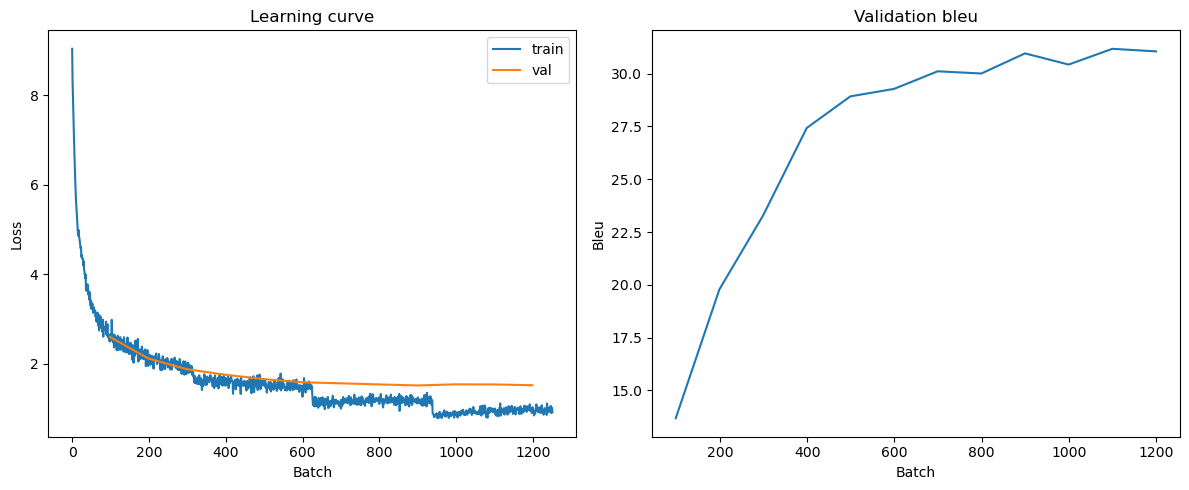

Time: 1m 16s
	Train Loss: 0.9 | Train PPL: 3
	 Val. Loss: 1.5 |  Val. PPL: 5
	 Bleu: 31.1


In [68]:
train_history, val_history, bleu_history, val_batches = train_and_plot(transformer, False, 4, transf_path,
                                                                       train_history, val_history, bleu_history, val_batches)

### Оценка качества



Считаем значения bleu на отложенной выборке и выводим примеры переводов

Базовая модель

In [ ]:
translated, target, bleu = get_bleu(model, test_loader)
print('Score:', round(bleu, 1))
print('Examples:')
for i in range(5):
  print('Target:', target[i])
  print('Translated:', translated[i])
  print('-----')

Score: 18.9
Examples:
Target: ['wake', 'up', 'to', 'a', 'delicious', 'complimentary', 'buffet', 'in', 'the', 'bright', 'pavilion', '.']
Translated: ['a', 'complimentary', 'breakfast', 'is', 'served', 'daily', 'in', 'the', 'breakfast', 'room', '.']
-----
Target: ['free', 'wifi', 'is', 'available', 'in', 'the', 'rooms', '.']
Translated: ['free', 'wi', '-', 'fi', 'is', 'available', '.']
-----
Target: ['the', 'hostel', 'also', 'offers', 'bike', 'hire', ',', 'car', 'hire', 'and', 'a', 'tour', 'and', 'activities', 'desk', '.']
Translated: ['bike', 'hire', 'and', 'car', 'hire', 'are', 'available', 'at', 'the', 'property', 'and', 'the', 'area', 'is', 'popular', 'for', 'golfing', '.']
-----
Target: ['the', 'centre', 'of', 'mondsee', 'is', '3', 'km', 'away', '.']
Translated: ['the', 'nearest', 'restaurant', 'is', '3', 'km', 'from', 'the', 'property', '.']
-----
Target: ['the', 'salem', 'inn', 'places', 'guests', 'within', 'walking', 'distance', 'to', 'a', 'variety', 'of', 'local', 'attractions',

Модель с Attention

In [ ]:
translated, target, bleu = get_bleu(model, test_loader)
print('Score:', round(bleu, 1))
print('Examples:')
for i in range(5):
  print('Target:', target[i])
  print('Translated:', translated[i])
  print('-----')

Score: 25.6
Examples:
Target: ['the', 'hotel', 'has', '24', '-', 'hour', 'front', 'desk', '.']
Translated: ['there', 'is', 'a', '24', '-', 'hour', 'front', 'desk', 'at', 'the', 'property', '.']
-----
Target: ['the', '<UNK>', 'enjoys', 'a', 'panoramic', 'position', 'in', 'san', 'martino', 'di', '<UNK>', ',', '150', 'meters', 'from', 'the', '<UNK>', 'chair', 'lift', ',', 'and', '1', '.', '5', 'km', 'from', 'the', '<UNK>', 'cable', 'way', '.']
Translated: ['the', '<UNK>', 'is', 'located', 'in', 'the', 'historic', 'town', 'of', '<UNK>', 'del', 'tronto', ',', '150', 'metres', 'from', 'the', '<UNK>', 'and', 'the', '<UNK>', 'cable', 'car', '.', 'the', '<UNK>', 'cable', 'car', 'is', '1', '.', '5', 'km', 'away', '.']
-----
Target: ['these', 'fully', '-', 'furnished', 'apartments', 'are', 'all', 'fitted', 'with', 'a', 'sofa', ',', 'free', 'toiletries', ',', 'a', 'flat', '-', 'screen', 'tv', 'with', 'cable', 'channels', ',', 'a', 'dining', 'area', ',', 'a', 'fully', '-', 'equipped', 'kitchen', 'a

Attention + изменение learning rate

In [ ]:
translated, target, bleu = get_bleu(model, test_loader)
print('Score:', round(bleu, 1))
print('Examples:')
for i in range(5):
  print('Target:', target[i])
  print('Translated:', translated[i])
  print('-----')

Score: 27.1
Examples:
Target: ['free', 'wifi', 'access', 'is', 'available', '.']
Translated: ['free', 'wifi', 'is', 'available', '.']
-----
Target: ['a', 'storage', 'room', 'for', 'ski', 'equipment', 'is', 'available', '.']
Translated: ['there', 'is', 'also', 'a', 'ski', 'storage', 'room', '.']
-----
Target: ['air', 'conditioning', 'and', 'a', 'balcony', 'with', 'an', 'outdoor', 'dining', 'area', 'are', 'also', 'included', '.']
Translated: ['the', 'air', '-', 'conditioned', 'apartment', 'has', 'a', 'balcony', 'with', 'dining', 'area', '.']
-----
Target: ['pisa', 'galileo', 'galilei', 'airport', 'is', '52', 'km', 'away', '.']
Translated: ['the', 'nearest', 'airport', 'is', 'elefthérios', 'venizélos', 'airport', ',', '33', 'km', 'from', 'the', 'property', '.']
-----
Target: ['guests', 'can', 'enjoy', 'a', 'variety', 'of', '<UNK>', 'valley', 'wines', 'at', 'the', 'property', '.']
Translated: ['the', 'owners', 'can', 'also', 'help', 'yourself', 'to', 'the', '<UNK>', '.']
-----


Трансформер

In [ ]:
bleu, translated, target = get_bleu(transformer, test_loader)
print('Score:', round(bleu, 1))
print('Examples:')
for i in range(5):
  print('Target:', target[i])
  print('Translated:', translated[i])
  print('-----')

Score: 31.1
Examples:
Target: ['offering', 'a', 'free', 'outdoor', 'pool', 'and', 'a', 'restaurant', ',', 'the', '4', '-', 'star', 'art', 'hotel', 'santorini', 'is', 'located', 'in', '<UNK>', '.']
Translated: ['offering', 'an', 'outdoor', 'pool', 'and', 'a', 'restaurant', ',', 'the', '4', '-', 'star', 'hotel', 'is', 'located', 'in', '<UNK>', '.']
-----
Target: ['<UNK>', 'university', 'is', '5', '.', '3', 'miles', 'away', '.']
Translated: ['the', '<UNK>', 'is', '8', '.', '5', 'km', 'away', '.']
-----
Target: ['the', 'air', '-', 'conditioned', 'rooms', 'are', 'spacious', 'and', 'feature', 'a', 'simple', 'décor', '.']
Translated: ['the', 'spacious', 'air', '-', 'conditioned', 'rooms', 'feature', 'a', 'simple', 'interior', '.']
-----
Target: ['the', 'hotel', 'features', 'a', 'large', 'outdoor', 'swimming', 'pool', 'and', 'free', 'wifi', '.']
Translated: ['it', 'offers', 'a', 'large', 'outdoor', 'pool', 'and', 'free', 'wi', '-', 'fi', '.']
-----
Target: ['the', 'nearest', 'airport', 'is', '

### Обсуждение результатов

1) Базовая модель Seq2Seq показывает не очень хорошее качество перевода и используется тут только для сравнения с более продвинутыми алгоритмами

2) Механизм attention позволяет значительно, на 10 пунктов, поднять значение bleu на отложенной выборке. При этом прочие условия: количество эпох, размер embedding и т. д. совпадают, хотя одна эпоха учится примерно в 1.3 раза дольше

3) Использование lr_scheduler ещё поднимает значение bleu, хотя и не так сильно, на 1.5 пункта

4) Использование трансформера значительно улучшает качество перевода, ещё на 4 пункта по сравнению с attention + lr_scheduler, при этом обучение идёт в 3 раза быстрее